In [1]:
import sys
# sys.path.append('/home/ajhnam/plinko_nn/src')
# sys.path.append('/home/plinkoproj/plinko_nn/src')
sys.path.append('../src')
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from plinko.misc import data_utils
from plinko.misc.simulation_dataset import SimulationDataset
# from plinko.model.predictor_gru import GRUPredictor
# from plinko.model.predictor_gru import GRUPredictor_mu
from plinko.model.predictor_gru import GRUPredictor_determ
from plinko.model.predictor_gru import GRUPredictor_determ_p
from plinko.misc import plot as plinko_plot

# import matplotlib.pyplot as plt
# from plotnine import *
# %matplotlib inline

Loading chipmunk for Windows (64bit) [C:\ProgramData\Miniconda3\lib\site-packages\pymunk\chipmunk.dll]


In [2]:
# device = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(0)
torch.manual_seed(0)
torch.set_default_tensor_type('torch.FloatTensor')
epsilon = sys.float_info.epsilon

In [34]:
# repo_path = '/home/plinkoproj/plinko_nn'
repo_path = '../'
df_ball = pd.read_feather(repo_path + '/data/simulations/sim_ball.feather')
df_env = pd.read_feather(repo_path + '/data/simulations/sim_environment.feather')
df_col = pd.read_feather(repo_path + '/data/simulations/sim_collisions.feather')

df_ball = pd.read_feather(repo_path + '/data/training/sim_ball.feather')
df_env = pd.read_feather(repo_path + '/data/training/sim_environment.feather')
df_col = pd.read_feather(repo_path + '/data/training/sim_collisions.feather')

In [35]:
# create df with collision data
collisions = df_col.copy()
collisions = collisions.rename({'object': 'collision'}, axis=1)
collisions.t -= 1
collisions = df_ball.merge(collisions, how='left')
collisions.collision[collisions.collision.isna()] = 'none'
collisions.collision[(collisions.collision == 'walls') & (collisions.px < 100)] = 'left_wall'
collisions.collision[(collisions.collision == 'walls') & (collisions.px > 500)] = 'right_wall'
collisions = collisions.sort_values(['simulation', 'run', 't'])
idx2col = sorted(collisions.collision.unique())
col2idx = {c: i for c, i in zip(idx2col, range(len(idx2col)))}
collisions['col'] = [col2idx[c] for c in collisions.collision]
df_collision = collisions.drop(columns="collision")

# if input collision at next time point
# next_col = collisions.groupby(['simulation', 'run'], as_index=False).apply(lambda x: x.iloc[1:]).reset_index().col
# df_collision = collisions.drop(columns="collision").groupby(['simulation', 'run'], as_index=False).apply(lambda x: x.iloc[:-1]).reset_index()
# df_collision.col = next_col


sim_data = data_utils.get_sim_data(df_collision, df_col)
selected_runs = sim_data[(sim_data.num_collisions == 2)
                         & (sim_data.duration < 80)
                         & (sim_data.run <= 10)]
simulations, environments = data_utils.create_task_df(selected_runs, df_collision, df_env)
states, envs = data_utils.to_tensors(simulations, environments, device, include_v=False, include_t=True)
# states[:, :, 2:4] = (states[:, :, 2:4] + 20) # transform velocity to all positive

# del collisions, df_collision, df_ball, df_env, df_col

In [5]:
# print(selected_runs)
# print(df_ball)
# simulations.t.max()
# print(df_col[df_col['simulation'] == 'sim_1'])

# del df_ball, df_env, df_col

# print(states.shape)
# print(envs.shape)
# print(states[0, :, 2])
# print(collisions[:20])
# print(df_collision[:20])
print(states[0])
# print(idx2col)
# print(simulations.col.unique())
# print(simulations)

tensor([[ 2.5451,  8.9033,  2.0000,  0.0000],
        [ 2.5391,  8.8720,  2.0000,  1.0000],
        [ 2.5332,  8.8348,  2.0000,  2.0000],
        [ 2.5273,  8.7917,  2.0000,  3.0000],
        [ 2.5213,  8.7426,  2.0000,  4.0000],
        [ 2.5154,  8.6875,  2.0000,  5.0000],
        [ 2.5095,  8.6265,  2.0000,  6.0000],
        [ 2.5035,  8.5596,  2.0000,  7.0000],
        [ 2.4976,  8.4867,  2.0000,  8.0000],
        [ 2.4917,  8.4078,  2.0000,  9.0000],
        [ 2.4857,  8.3230,  2.0000, 10.0000],
        [ 2.4798,  8.2322,  2.0000, 11.0000],
        [ 2.4738,  8.1355,  2.0000, 12.0000],
        [ 2.4679,  8.0329,  2.0000, 13.0000],
        [ 2.4620,  7.9242,  2.0000, 14.0000],
        [ 2.4560,  7.8097,  2.0000, 15.0000],
        [ 2.4501,  7.6891,  3.0000, 16.0000],
        [ 2.4751,  7.6487,  2.0000, 17.0000],
        [ 2.5121,  7.6356,  2.0000, 18.0000],
        [ 2.5510,  7.6218,  2.0000, 19.0000],
        [ 2.5918,  7.6073,  2.0000, 20.0000],
        [ 2.6344,  7.5922,  2.0000

In [26]:
# model = GRUPredictor(env_size=11, state_size=2, num_gaussians=2).to(device)
# model = GRUPredictor_mu(env_size=11, state_size=2, num_gaussians=1, trainable_h0 = True).to(device)
# model = GRUPredictor_determ(env_size=9, state_size=6, gru_hidden_size=128, num_gaussians=1, trainable_h0 = True).to(device)
model = GRUPredictor_determ_p(env_size=9, state_size=4, gru_hidden_size=128, num_gaussians=1, trainable_h0 = True).to(device)
# optimizer = optim.SGD(model.parameters(), lr=.001)
optimizer = optim.Adam(model.parameters(), lr = 10e-4, weight_decay=.001)
dataset = SimulationDataset(envs, states)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

In [21]:
# Train GRU_deterministic

optimizer = optim.Adam(model.parameters(), lr = 1e-4, weight_decay=.001)

max_t = simulations.t.max()
epochs = 1000
losses = []
p_overtime = []
v_overtime = []
target_overtime = []
rows = []
# for epoch in tqdm(range(epochs+1)):
for epoch in tqdm(range(101)):
    epoch_loss = 0
    epoch_p_loss = 0
    epoch_v_loss = 0
    epoch_col_loss = 0
    for batch_i, batch in enumerate(dataloader):
        optimizer.zero_grad()

        #         print('Batch ', batch_i)
#         p_batch, v_batch, t_batch, col_outputs = model(batch['envs'][:, :9], batch['states'], 0)
        p_batch, t_batch, col_outputs = model(batch['envs'][:, :9], batch['states'], 0)
        targets = batch['targets']

        p_mse_loss = F.mse_loss(p_batch, targets[:, :, :2])
#         v_mse_loss = F.mse_loss(v_batch, targets[:, :, 2:4])
#         col_targets = torch.tensor(batch['states'][:, :, 4].reshape(-1), dtype=torch.long, device=device)
        col_targets = torch.tensor(batch['states'][:, :, 2].reshape(-1), dtype=torch.long, device=device)
        col_loss = F.cross_entropy(col_outputs, col_targets)
#         loss = p_mse_loss + v_mse_loss + col_loss
        loss = p_mse_loss + col_loss
        loss.backward(retain_graph=True)
        optimizer.step()
        epoch_loss += loss
        epoch_p_loss += p_mse_loss
#         epoch_v_loss += v_mse_loss
        epoch_col_loss += col_loss

    losses.append((epoch, float(epoch_p_loss), float(epoch_v_loss), float(epoch_col_loss),))
        

    if epoch % 1 == 0:
        print('Epoch {} | p_loss: {} | v_loss: {} | col_loss: {} | total: {}'.format(epoch,
                                                                      round(float(epoch_p_loss), 4),
                                                                      round(float(epoch_v_loss), 4),
                                                                      round(float(epoch_col_loss), 4),
                                                                      round(float(epoch_loss), 4)))
        corrects = (col_outputs.argmax(-1) == col_targets).float()
        accuracy = float(corrects.mean())
        print("accuracy", round(accuracy, 4))
        row = {'epoch': epoch, 'corrects': corrects, 'acc_total': accuracy}
        rows.append(row)
        
summary = pd.DataFrame(rows)

#     if (loss - prev_loss) < .1 and (loss - prev_loss) > -.1:
#         break

torch.save(model.state_dict(), 'gru_determ_p_col.model')
torch.save(losses, 'losses_determ_p_col.pt')
summary.to_csv('col_classif_accuracy_determ_p_col.csv')

Epoch 0 | p_loss: 0.211 | v_loss: 0.0 | | col_loss: 9.5374 | total: 9.7483
accuracy 0.9747
Epoch 1 | p_loss: 0.0679 | v_loss: 0.0 | | col_loss: 9.5347 | total: 9.6026
accuracy 0.9747
Epoch 2 | p_loss: 0.0706 | v_loss: 0.0 | | col_loss: 9.5337 | total: 9.6043
accuracy 0.9747
Epoch 3 | p_loss: 0.0762 | v_loss: 0.0 | | col_loss: 9.5327 | total: 9.6089
accuracy 0.9747
Epoch 4 | p_loss: 0.071 | v_loss: 0.0 | | col_loss: 9.5318 | total: 9.6027
accuracy 0.9747
Epoch 5 | p_loss: 0.0696 | v_loss: 0.0 | | col_loss: 9.5308 | total: 9.6004
accuracy 0.9747
Epoch 6 | p_loss: 0.0682 | v_loss: 0.0 | | col_loss: 9.5298 | total: 9.598
accuracy 0.9747
Epoch 7 | p_loss: 0.0685 | v_loss: 0.0 | | col_loss: 9.5288 | total: 9.5973
accuracy 0.9747
Epoch 8 | p_loss: 0.0698 | v_loss: 0.0 | | col_loss: 9.5278 | total: 9.5976
accuracy 0.9747
Epoch 9 | p_loss: 0.0713 | v_loss: 0.0 | | col_loss: 9.5268 | total: 9.5981
accuracy 0.9747
Epoch 10 | p_loss: 0.0721 | v_loss: 0.0 | | col_loss: 9.5258 | total: 9.5979
accura

Epoch 89 | p_loss: 0.0778 | v_loss: 0.0 | | col_loss: 9.3536 | total: 9.4314
accuracy 0.9747
Epoch 90 | p_loss: 0.0779 | v_loss: 0.0 | | col_loss: 9.3485 | total: 9.4264
accuracy 0.9747
Epoch 91 | p_loss: 0.078 | v_loss: 0.0 | | col_loss: 9.3433 | total: 9.4212
accuracy 0.9747
Epoch 92 | p_loss: 0.078 | v_loss: 0.0 | | col_loss: 9.3379 | total: 9.4159
accuracy 0.9747
Epoch 93 | p_loss: 0.078 | v_loss: 0.0 | | col_loss: 9.3323 | total: 9.4102
accuracy 0.9747
Epoch 94 | p_loss: 0.0778 | v_loss: 0.0 | | col_loss: 9.3265 | total: 9.4043
accuracy 0.9747
Epoch 95 | p_loss: 0.0774 | v_loss: 0.0 | | col_loss: 9.3206 | total: 9.398
accuracy 0.9747
Epoch 96 | p_loss: 0.0768 | v_loss: 0.0 | | col_loss: 9.3145 | total: 9.3913
accuracy 0.9747
Epoch 97 | p_loss: 0.0762 | v_loss: 0.0 | | col_loss: 9.3082 | total: 9.3845
accuracy 0.9747
Epoch 98 | p_loss: 0.0757 | v_loss: 0.0 | | col_loss: 9.3017 | total: 9.3774
accuracy 0.9747
Epoch 99 | p_loss: 0.075 | v_loss: 0.0 | | col_loss: 9.295 | total: 9.37
a

In [68]:
print(col_targets[:100])
print(col_outputs.argmax(-1)[:100])

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2,
        2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2], device='cuda:0')


In [49]:
# print(p_batch[0, :10])
# print(targets[0, :10, :])

# print(col_outputs.argmax(-1)[200:400])
# print(col_targets[200:400])
# print(p_overtime[50])
# print(targets[:, :, :2].shape)

# print(summary)

# p = (ggplot(summary, aes('epoch', 'acc_total'))
#         + geom_path(alpha = .7)
#         + geom_point(alpha = .7)
#          + ylim(.95, 1)
#         + labs(title = 'Classification accuracy')
#         )
# print(p)

# print(batch['states'][0, :, 4])
# print(20 - targets[0, :, 2:4])


# visualize prediction error in velocity
df_v_diff = pd.DataFrame((v_batch[0] - targets[0, :, 2:4]).data.cpu().numpy(), columns = ['vx_diff', 'vy_diff'])
df_v_diff['time'] = range(len(df_v_diff))
df_v_diff_long = pd.melt(df_v_diff, id_vars= 'time', var_name='type', value_name='v_diff')
df_v_diff_long


import matplotlib.pyplot as plt
from plotnine import *

p = (ggplot(df_v_diff_long, aes('time', 'v_diff', color = 'type'))
    + geom_path(alpha = .7)
#     + geom_point(alpha = .7)
     + ylim(-1, 1)
    )
print(p)

In [29]:
# p_overtime = torch.load('p_overtime.pt')
# v_overtime = torch.load('v_overtime.pt')
# target_overtime = torch.load('target_overtime.pt')
losses = torch.load('losses_determ_p_col.pt')
# print(losses)

# model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load('gru_determ_p_col.model', map_location=torch.device('cpu')))
model.eval()

GRUPredictor_determ_p(
  (env_embedder): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=9, out_features=32, bias=True)
    )
  )
  (state_embedder): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=32, bias=True)
    )
  )
  (gru): GRU(64, 128, num_layers=2)
  (mlp): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=2, bias=True)
    )
  )
  (col_classifier): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=11, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=32, bias=True)
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Linear(in_features=32, out_features=32, bias=True)
      (4): Linear(in_features=32, out_features=32, bias=True)
      (5): Linear(in_features=32, out_features=7, bias=True)
    )
  )
)

In [36]:
testset = SimulationDataset(envs, states)
# print(states.shape)

def get_test_loss(model, testset):
    dataloader = DataLoader(testset, batch_size=len(testset), shuffle=False)
    i = 0
    for batch in dataloader:
        i += 1
        with torch.no_grad():
            p_batch, t_batch, col_outputs = model(batch['envs'][:, :9], batch['states'], 0)
            targets = batch['targets']

            p_mse_loss = float(F.mse_loss(p_batch, targets[:, :, :2]))
            print('test loss:', p_mse_loss)

            return p_mse_loss
        
test_loss = get_test_loss(model, testset)

torch.Size([2718, 80, 4])
test loss: 0.002995678223669529


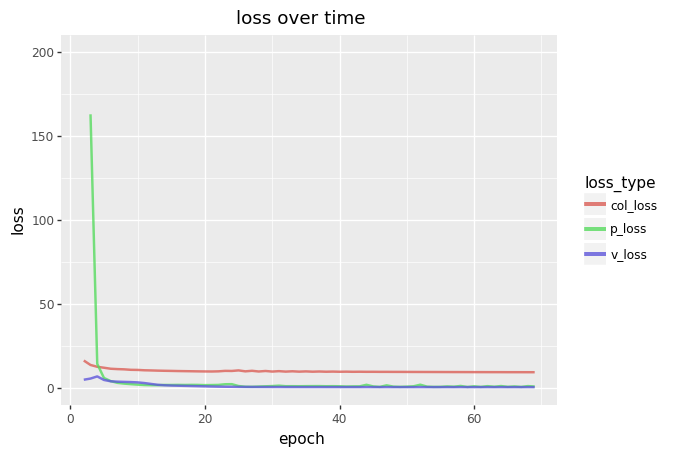

<ggplot: (8769983515189)>


In [27]:
# print(losses)
import matplotlib.pyplot as plt
from plotnine import *

def plot_losses(losses, time_range = None, title = 'loss over time', alpha = .5, shape = '.',filename=None):
    """
    :losses: tuples or array of losses (each row is one timepoint, and the 3 columns are epoch, batch_i, and loss)
    :time_range: the range in timepoint you want to plot
    :title: title of the plot
    :return: plot the loss over time
    """
    df_losses = pd.DataFrame(losses, columns =['epoch', 'p_loss', 'v_loss', 'col_loss'])
    if time_range is None:
        time_range = range(len(df_losses))
    df_losses_long = pd.melt(df_losses, id_vars= ['epoch'], var_name='loss_type', value_name='loss')
    df_losses_long['loss_type'] = df_losses_long['loss_type'].astype('str') 
#     print(df_losses.dtypes)
#     print(df_losses_long.dtypes)

    p = (ggplot(df_losses_long, aes('epoch', 'loss', color = 'loss_type'))
        + geom_path(alpha = alpha, size = 1)
#         + geom_point(alpha = alpha, shape = shape)
        + xlim(time_range[0], time_range[-1])
        + ylim(0, 200)
        + labs(title = title)
        )
    print(p)
    if filename is not None:
        ggsave(filename=filename,
               plot=p,
               device='png')

# df_losses = pd.DataFrame(losses, columns =['epoch', 'p_loss', 'v_loss', 'col_loss'])
# df_losses.apply(pd.to_numeric)
# df_losses_long = pd.melt(df_losses, id_vars= ['epoch'], var_name='loss_type', value_name='loss')
# df_losses_long['type'] = df_losses_long.loss_type.astype(str)
# print(df_losses.dtypes)
# print(df_losses_long.dtypes)


plot_losses(losses, alpha = .8, time_range = range(2, 70))
        
# plinko_plot.plot_losses(losses)

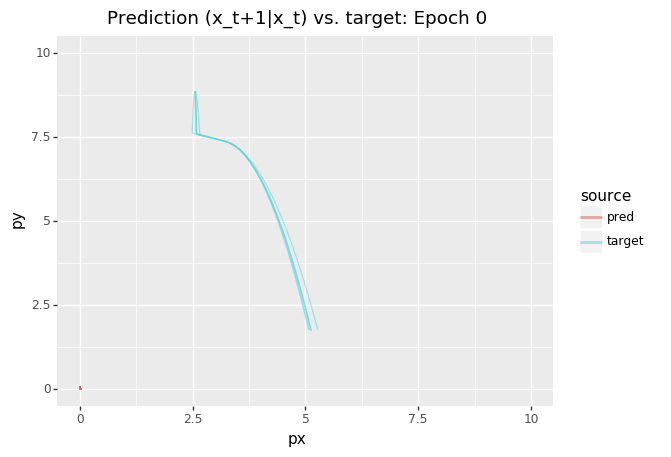

<ggplot: (8769983821997)>


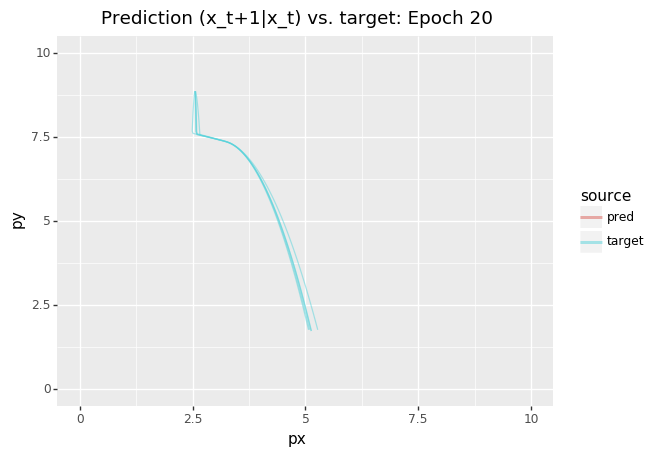

<ggplot: (8769983655669)>


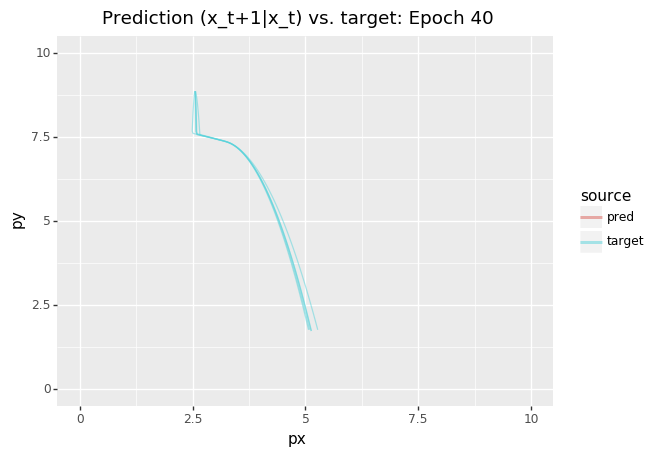

<ggplot: (8769983448121)>


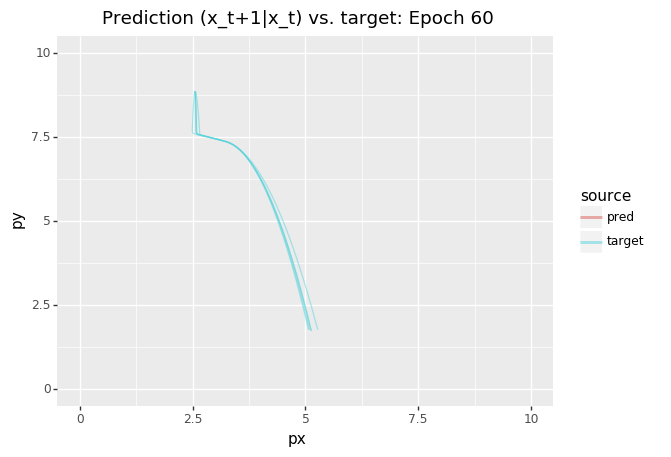

<ggplot: (8769983287901)>


In [28]:
# print(target_overtime[0][:, :, 2:])
# print(p_overtime[0].shape)
# print(v_overtime[0])

for t in range(len(p_overtime)):
    if t %20 == 0:
        plinko_plot.plot_pred_target(p_overtime[t], target_overtime[t][:, :, :2], sim_range = range(10, 15), alpha = .5,
                                    title = "Prediction (x_t+1|x_t) vs. target: Epoch {}".format(t))

In [37]:
def simulate_model(model, dataset, sim_t=1):
    """
    :sim_t = how many time points to feed in for the simulation
    """
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    i = 0
    for batch in dataloader:
        i += 1
        with torch.no_grad():
#             p, v = model(batch['envs'][:, :9], batch['states'][:, 0:sim_t], dataset[0]['states'].shape[0] - sim_t)
#             p_pred, v_pred, t_pred, col_pred = model(batch['envs'][:, :9], batch['states'], 0)
            p = model(batch['envs'][:, :9], batch['states'][:, 0:sim_t], dataset[0]['states'].shape[0] - sim_t)
            p_pred, t_pred, col_pred = model(batch['envs'][:, :9], batch['states'], 0)
            targets = batch['targets'][:, 1:101]
            envs = batch['envs']
            #             df_env, df_ball = data_utils.create_simdata_from_samples(samples, batch['envs'],sim_df, env_df)

            return p_pred, p, targets, envs

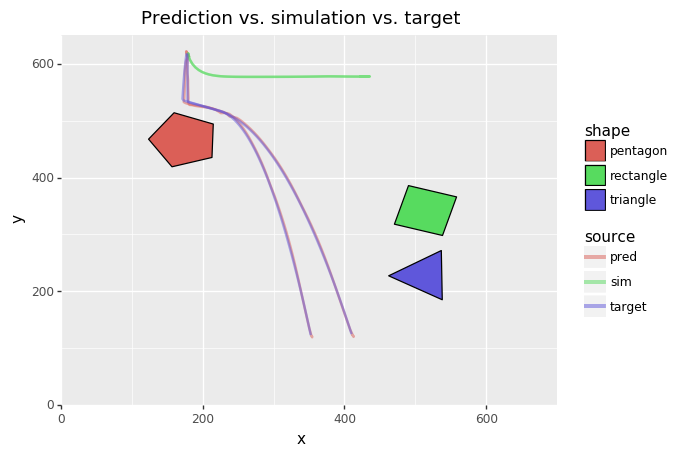

<ggplot: (-9223371847695465412)>


In [42]:
# print(sim_samples.shape)
# print(sim_targets.shape)
# print(gm.mu.shape)

# print(dataset[0]['states'].shape[0])
# simulate from trained model
# pred_p, sim_p, sim_targets, sim_envs = simulate_model(model, dataset, sim_t = 1)

plinko_plot.plot_pred_sim_target(pred_p, sim_p, sim_targets[:, :, :2], sim_envs, 
                                 sim_range=range(2), env_index = 0, alpha = .5, size = 1, leg_position = 'right',
                                    filename = 'plot1_determ_p_col', file_width = 6, file_height = 6 * 8 /7)

In [38]:
print(sim_p[0].shape)

torch.Size([74, 2])
